### 勾配爆発への対策

In [1]:
import numpy as np
dW1 = np.random.randn(3, 3) * 10
dW2 = np.random.randn(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

clip_grads(grads, max_norm)

### LSTMの実装

In [2]:
import functions

In [3]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = functions.sigmoid(f)
        g = np.tanh(g)
        i = functions.sigmoid(i)
        o = functions.sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

### TimeLSTMの実装

In [4]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empyu((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
        
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        
        self.dh = dh
        return dxs
    
    def set_state(self, h, c=None):
        self.h, self.c = h, c
    
    def reset_state(self):
        self.h, self.c = None, None

### LSTMを使った言語モデル

In [5]:
import pickle
import time_layers

In [9]:
class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size , wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            time_layers.TimeEmbedding(embed_W),
            time_layers.TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            time_layers.TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = time_layers.TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
    
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

### 学習

In [11]:
import optimizer
import trainer
import util
import ptb

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9999.78
| epoch 1 |  iter 21 / 1327 | time 7[s] | perplexity 3049.02
| epoch 1 |  iter 41 / 1327 | time 14[s] | perplexity 1207.01
| epoch 1 |  iter 61 / 1327 | time 20[s] | perplexity 985.55
| epoch 1 |  iter 81 / 1327 | time 27[s] | perplexity 803.29
| epoch 1 |  iter 101 / 1327 | time 33[s] | perplexity 649.42
| epoch 1 |  iter 121 / 1327 | time 40[s] | perplexity 656.30
| epoch 1 |  iter 141 / 1327 | time 46[s] | perplexity 597.16
| epoch 1 |  iter 161 / 1327 | time 53[s] | perplexity 582.15
| epoch 1 |  iter 181 / 1327 | time 60[s] | perplexity 576.57
| epoch 1 |  iter 201 / 1327 | time 66[s] | perplexity 494.03
| epoch 1 |  iter 221 / 1327 | time 73[s] | perplexity 499.45
| epoch 1 |  iter 241 / 1327 | time 79[s] | perplexity 450.35
| epoch 1 |  iter 261 / 1327 | time 86[s] | perplexity 445.00
| epoch 1 |  iter 281 / 1327 | time 92[s] | perplexity 449.63
| epoch 1 |  iter 301 / 1327 | time 99[s] | perplexity 400.35
| epoch 1 |  

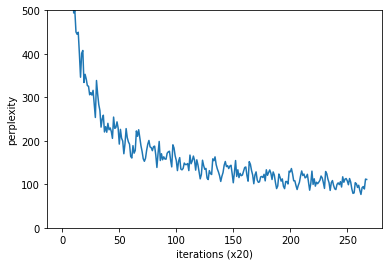

evaluating perplexity ...
234 / 235
test perplexity: 134.9986617088592


In [12]:
# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100 # RNNの隠れ状態ベクトルの要素数
time_size = 35 # RNNを展開するサイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = optimizer.SGD(lr)
trainer = trainer.RnnlmTrainer(model, optimizer)

# ①勾配クリップングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# ②テストデータで評価
model.reset_state()
ppl_test = util.eval_perplexity(model, corpus_test)
print('test perplexity:', ppl_test)

# ③パラメータの保存
model.save_params()

In [14]:
import base_model

In [15]:
class BetterRnnlm(base_model.BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=650):
        V, D, H = vocab_size , wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            time_layers.TimeEmbedding(embed_W),
            time_layers.TimeDropout(dropout_ratio),
            time_layers.TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            time_layers.TimeDropout(dropout_ratio),
            time_layers.TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            time_layers.TimeDropout(dropout_ratio),
            time_layers.TimeAffine(embed_W.T, affine_b)
        ]
        self.loss_layer = time_layers.TimeSoftmaxWithLoss()
        self.lstm_layer = [self.layers[2], self.layers[4]]
        self.drop_layer = [self.layers[1], self.layers[3], self.layers[5]]

        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, xs, train_flg=True):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, Train_flg=True):
        score = self.predict(xs, Train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [ ]:
import config

# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = util.to_gpu(corpus)
    corpus_val = util.to_gpu(corpus_val)
    corpus_test = util.to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = optimizer.SGD(lr)
trainer = trainer.RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = util.eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# テストデータでの評価
model.reset_state()
ppl_test = util.eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)